In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import display, Image, Javascript

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from functions import get_bar_plot_of_mean_label

In [2]:
df = pd.read_csv("corona_tested_individuals_ver_005.csv", low_memory=False)
display(df.head(4))
print(f"Shape: {df.shape}")

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-25,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
1,2020-04-25,0.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other
2,2020-04-25,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
3,2020-04-25,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Abroad


Shape: (247122, 10)


In [3]:
df['gender'] = df['gender'].apply(lambda g: 0 if g == 'female' else 1)
df['age_60_and_above'] = df['age_60_and_above'].apply(lambda val: 1 if val == 'Yes' else 0)
df['label'] = df['corona_result'].apply(lambda val: 1 if val == 'positive' else (0 if val=='negative' else None))

CLASS_LABEL = 'label'
features = ['gender', 'age_60_and_above', 'fever', 'head_ache', 'cough', 'shortness_of_breath', 'sore_throat']

df[CLASS_LABEL].value_counts()

0.0    229512
1.0     14161
Name: label, dtype: int64

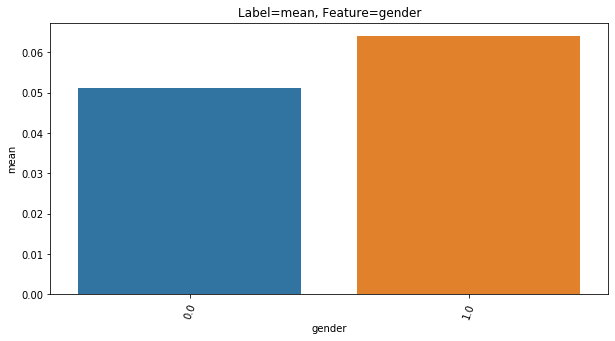

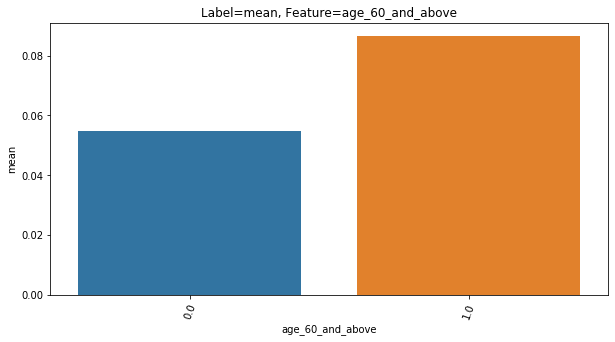

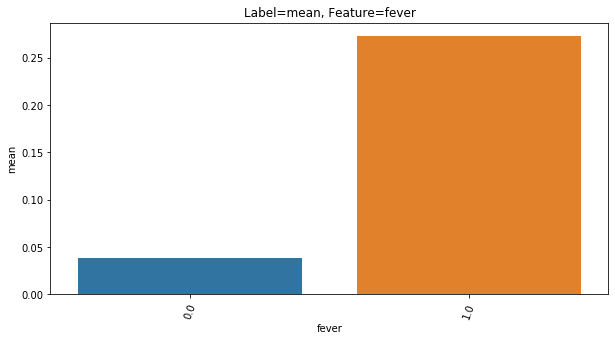

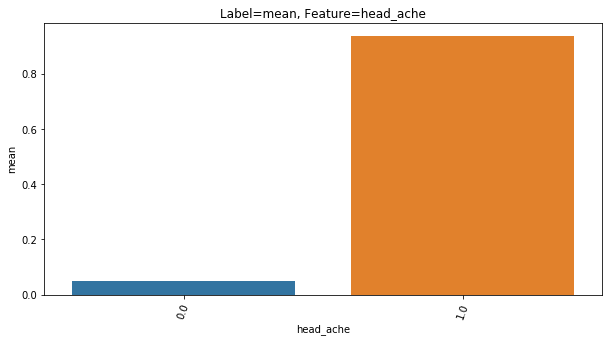

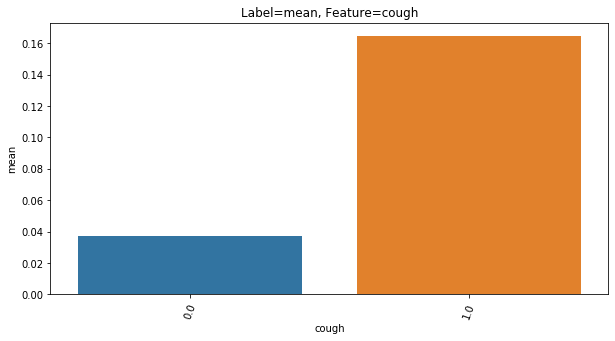

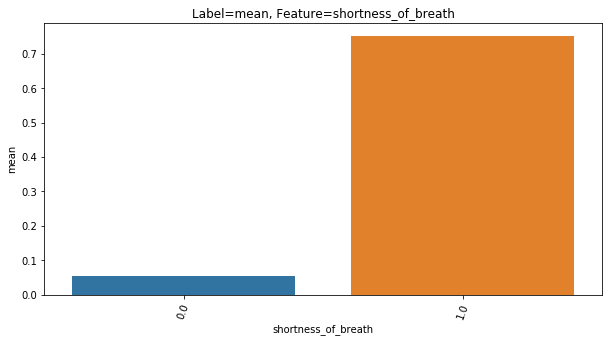

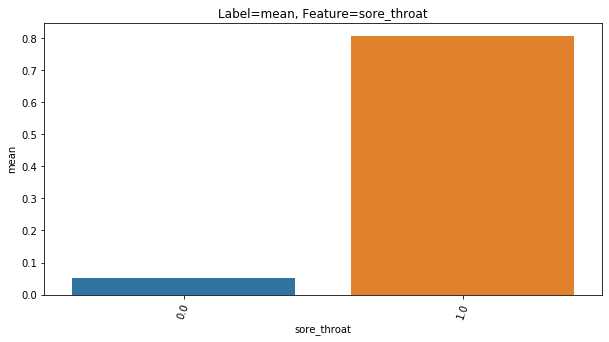

<Figure size 432x288 with 0 Axes>

In [4]:
for feature in features:
    get_bar_plot_of_mean_label(df, feature, CLASS_LABEL, q=10, title=None, xlabel=None, ylabel=None, toShow=True,
                               toDisplayData=False, toSave=False, fileName=None, toReturnData=False)

In [5]:
df = df.dropna()

X = df[~pd.isna(df[CLASS_LABEL])][features]
if CLASS_LABEL in X.columns:
    X = X.drop(CLASS_LABEL, 1)
y = df[~pd.isna(df[CLASS_LABEL])][CLASS_LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [6]:
clf = AdaBoostClassifier()
gridValues = {'n_estimators':list(range(10,100,10))}
clfTuned = GridSearchCV(clf, param_grid = gridValues, cv=3, scoring = 'accuracy', iid=False)
clfTuned.fit(X_train, y_train)
print(f"""AUC: {roc_auc_score(y_test, clfTuned.best_estimator_.predict_proba(X_test)[:, 1])}, Accuracy: {clfTuned.best_score_}""")

pickle.dump(clfTuned.best_estimator_, open('model.pkl', "wb"))

AUC: 0.7787742343135513, Accuracy: 0.9525292772187322


In [7]:
# Checking what the prediction for all form fill options in the web app

resultsDf = pd.DataFrame(columns=features+['prediction'])
i=0
for gender in [0,1]:
    for age_60_and_above in [0,1]:
        for fever in [0,1]:
            for headache in [0,1]:
                for cough in [0,1]:
                    for shortness_of_breath in [0,1]:
                        for sore_throat in [0,1]:
                            features_list = [gender, age_60_and_above, fever, headache, cough, shortness_of_breath, sore_throat]
                            features_array = [np.array(features_list)]
                            prediction = clfTuned.predict_proba(features_array)[:,1][0]
                            resultsDf.loc[i] = [gender, age_60_and_above, fever, headache, cough, shortness_of_breath, sore_throat, prediction]
                            i += 1

In [8]:
resultsDf.sort_values(by='prediction', ascending=False)

,gender,age_60_and_above,fever,head_ache,cough,shortness_of_breath,sore_throat,prediction
127,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.673336
63,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.669755
95,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.662289
31,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.658649
123,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.655377
...,...,...,...,...,...,...,...,...
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.427786
96,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.424235
32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.420275
64,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412120
